In [9]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import holidays
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
pd.set_option('display.max_columns',60)

## Step 1: Define Helper Functions

In [2]:
csv_files_2017 = [('2017' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files_2018 = [('2018' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files_2019 = [('2019' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files = csv_files_2017 + csv_files_2018 + csv_files_2019

In [3]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [4]:
def time_parser(df):
    df1 = df.copy()
    df1['starttime'] = pd.to_datetime(df1['starttime'])
    df1['stoptime'] = pd.to_datetime(df1['stoptime'])
    df1['start_date'] = df1['starttime'].dt.date
    df1['start_year'] = df1['starttime'].dt.year
    df1['start_month'] = df1['starttime'].dt.month
    df1['start_day'] = df1['starttime'].dt.day
    df1['start_hour'] = df1['starttime'].dt.hour
    df1['start_dayofweek'] = df1['starttime'].dt.weekday+1   # Monday is 1, Sunday is 7
    df1['Isweekday'] = [0 if 6<=x<=7 else 1 for x in df1['start_dayofweek']]
    NYholidays = holidays.UnitedStates(state = 'NY')
    df1['holidays'] = list(map(lambda x: x in NYholidays, df1.start_date)) 
    df1['holidays'] = df1['holidays'].map({True:1,False:0})
#     df1['start_min'] = df1['starttime'].dt.minute
#     df1['start_time'] = df1['starttime'].dt.time
#     df1['start_dayofweek'] = df1['starttime'].dt.weekday_name  # The name of day in a week (e.g. Monday)
    df1['stop_date'] = df1['stoptime'].dt.date
#     df1['stop_time'] = df1['stoptime'].dt.time
    df1['stop_hour'] = df1['stoptime'].dt.hour
#     df1['stop_min'] = df1['stoptime'].dt.minute
#     df1['stop_dayofweek'] = df1['stoptime'].dt.weekday
    mask = df1['start_hour'].apply(lambda x: 5 <= x <= 22) # Remove offpeak hours(from 10pm-5am)
    return df1[mask]

In [5]:
def aggregated_data(df):
    # Define distance: if same start and end location, use average speed of 7.456mph to estimate distance.
    # If different locations, calculate Manhattan distance between two stations
    df['distance']=np.where(df['start_station_ID'] == df['end_station_ID'],df['trip_duration']*7.456/3600,
                            abs(df['start_station_longitude']-df['end_station_longitude'])*53+\
                            abs(df['start_station_latitude']-df['end_station_latitude'])*69)
    # Daily average of all stations for time-series analysis
    df_daily = df.groupby('start_date').agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_daily.columns = ['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']
    df_daily_merged = df.merge(df_daily, how = 'left', on = 'start_date')
    # Hourly average for each station regardeless of days 
    df_hourly = df.groupby(['start_station_ID','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly.columns = ['start_station_ID','start_hour','trip_per_hour','hourly_avg_trip_duration','hourly_avg_distance']
    df_hourly_merged = df_daily_merged.merge(df_hourly, how = 'left', on = ['start_station_ID','start_hour'])
    # Calculate hourly trip counts, avg trip duration, and avg trip distance per station and merge to above df
    df_hourly_eachday = df.groupby(['start_station_ID','start_date','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly_eachday.columns = ['start_station_ID','start_date','start_hour','trip_per_hour_eachday',
                                 'hourly_avg_trip_duration_eachday','hourly_avg_distance_eachday']
    df_hourly_eachday_merged = df_hourly_merged.merge(df_hourly_eachday, how = 'left',
                                                      on = ['start_station_ID','start_date','start_hour'])
    return df_hourly_eachday_merged    

In [6]:
def merge_bikecount(df):
    # groupby start station ID, date and hour to get hourly counts of trips per start station
    checkout = df.groupby(['start_station_ID','start_date','start_hour'])['trip_duration'].count().reset_index()
    checkout.columns = ['start_station_ID','start_date','start_hour','checkout_counts']
    # groupby end station ID, date, and hour to get hourly counts of trips per end station 
    checkin = df.groupby(['end_station_ID','stop_date','stop_hour'])[['trip_duration']].count().reset_index()
    checkin.columns=['end_station_ID','stop_date','stop_hour','checkin_counts']
    # Join dataframe to get station checkin and checkout counts 
    temp = pd.merge(checkout, checkin,  how='outer', left_on=['start_station_ID','start_date','start_hour'], 
                    right_on = ['end_station_ID','stop_date','stop_hour'])
    temp['start_station_ID'] = temp['start_station_ID'].fillna(temp['end_station_ID'])
    temp['start_date'] = temp['start_date'].fillna(temp['stop_date'])
    temp['start_hour'] = temp['start_hour'].fillna(temp['stop_hour'])
    temp['checkout_counts'] = temp['checkout_counts'].fillna(0)
    temp['checkin_counts'] = temp['checkin_counts'].fillna(0)
    temp = temp.drop(['end_station_ID','stop_date','stop_hour'],axis=1)
    temp.columns=['station_ID','date','hour','checkout_counts','checkin_counts']
    temp['total_counts'] = temp['checkin_counts'] + temp['checkout_counts']
    # merge orginal dataframe to get hourly checkin/checkout information for both start and stop stations 
    df_temp_merged = pd.merge(df, temp,  how='left', left_on=['start_station_ID','start_date','start_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1)
    df_temp_merged = pd.merge(df_temp_merged, temp,  how='left', left_on=['end_station_ID','stop_date','stop_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1) 
    df_temp_merged = df_temp_merged.rename(columns={'checkout_counts_x':'start_station_checkout_counts',
                                                    'checkin_counts_x':'start_station_checkin_counts',
                                                    'total_counts_x':'start_station_total_counts', 
                                                    'checkout_counts_y':'end_station_checkout_counts',
                                                    'checkin_counts_y':'end_station_checkin_counts',
                                                    'total_counts_y':'end_station_total_counts'}) 
    return df_temp_merged
    

## Step 2: Merge Monthly Datasets

In [7]:
total_time = 0
random.seed(0)
path = '../Tripdata/'
for i, csv in enumerate(csv_files):
    start_time = time.time()
    df_temp = pd.read_csv(path+csv)
    df_temp.columns = ['trip_duration','starttime','stoptime','start_station_ID','start_station_name',
                       'start_station_latitude','start_station_longitude','end_station_ID','end_station_name',
                       'end_station_latitude','end_station_longitude','bike_ID','user_type','birth_year','gender']
    df_temp = df_temp.loc[df_temp['trip_duration']<= 24*3600] # remove trips that are longer than 1 day 
    df_temp = df_temp.loc[(df_temp['start_station_latitude']>40) & (df_temp['start_station_latitude']<41)] # remove areas that are not in NYC (equator and montreal)
    df_temp = time_parser(df_temp)
    df_temp = merge_bikecount(df_temp)
    df_temp = aggregated_data(df_temp)
    
    # take a 5% subset of monthly file for analysis and another 5% of the remaining dataset as test dataset for ML
    rows = len(df_temp)
    size = int(rows/20)
    random.seed(0)
    selected_idx = random.sample(range(1,rows), size)
    skip_idx = list(set(df_temp.index)-set(selected_idx))
    test_idx = random.sample(skip_idx,int(len(skip_idx)/20))
    df_train = df_temp.iloc[selected_idx,:].drop(['user_type','birth_year','gender'],axis=1)
    df_test = df_temp.iloc[test_idx,:].drop(['user_type','birth_year','gender'],axis=1)
    
    # save train and test datset 
    df_train.to_csv(months[i%12] + csv[:4] + 'train.csv')
    df_test.to_csv(months[i%12] + csv[:4] + 'test.csv')
    print('Finishing data extraction from ' + csv)
    timeSpent = time.time() - start_time
    print('This iteration uses %.2f'%(timeSpent))
    total_time += timeSpent
print(total_time)

Finishing data extraction from 201701-citibike-tripdata.csv
This iteration uses 21.92
Finishing data extraction from 201702-citibike-tripdata.csv
This iteration uses 30.73
Finishing data extraction from 201703-citibike-tripdata.csv
This iteration uses 25.83
Finishing data extraction from 201704-citibike-tripdata.csv
This iteration uses 46.18
Finishing data extraction from 201705-citibike-tripdata.csv
This iteration uses 55.86
Finishing data extraction from 201706-citibike-tripdata.csv
This iteration uses 57.57
Finishing data extraction from 201707-citibike-tripdata.csv
This iteration uses 61.22
Finishing data extraction from 201708-citibike-tripdata.csv
This iteration uses 61.42
Finishing data extraction from 201709-citibike-tripdata.csv
This iteration uses 65.85
Finishing data extraction from 201710-citibike-tripdata.csv
This iteration uses 63.47
Finishing data extraction from 201711-citibike-tripdata.csv
This iteration uses 44.03
Finishing data extraction from 201712-citibike-tripdat

In [8]:
train_list = []
test_list = []
for i, csv in enumerate(csv_files):
    train_list.append(months[i%12] + csv[:4] + 'train.csv')
    test_list.append(months[i%12] + csv[:4] + 'test.csv')

In [9]:
# Merge all months train.csv into one train dataframe
train_df = pd.DataFrame()
for i in range(len(train_list)):
    temp_df = pd.read_csv(train_list[i], index_col = 0)
    train_df = pd.concat([train_df, temp_df], axis = 0)
    print('Finished ' + str(i) + ' element')
#train_df.to_csv('train.csv')

Finished 0 element
Finished 1 element
Finished 2 element
Finished 3 element
Finished 4 element
Finished 5 element
Finished 6 element
Finished 7 element
Finished 8 element
Finished 9 element
Finished 10 element
Finished 11 element
Finished 12 element
Finished 13 element
Finished 14 element
Finished 15 element
Finished 16 element
Finished 17 element
Finished 18 element
Finished 19 element
Finished 20 element
Finished 21 element
Finished 22 element
Finished 23 element
Finished 24 element
Finished 25 element
Finished 26 element
Finished 27 element
Finished 28 element
Finished 29 element
Finished 30 element
Finished 31 element
Finished 32 element
Finished 33 element
Finished 34 element
Finished 35 element


In [10]:
#Merge all months test.csv into one test dataframe
test_df = pd.DataFrame()
for i in range(len(test_list)):
    temp_df = pd.read_csv(test_list[i], index_col = 0)
    test_df = pd.concat([test_df, temp_df], axis = 0)
    print('Finished ' + str(i) + ' element')
#test_df.to_csv('test.csv')

Finished 0 element
Finished 1 element
Finished 2 element
Finished 3 element
Finished 4 element
Finished 5 element
Finished 6 element
Finished 7 element
Finished 8 element
Finished 9 element
Finished 10 element
Finished 11 element
Finished 12 element
Finished 13 element
Finished 14 element
Finished 15 element
Finished 16 element
Finished 17 element
Finished 18 element
Finished 19 element
Finished 20 element
Finished 21 element
Finished 22 element
Finished 23 element
Finished 24 element
Finished 25 element
Finished 26 element
Finished 27 element
Finished 28 element
Finished 29 element
Finished 30 element
Finished 31 element
Finished 32 element
Finished 33 element
Finished 34 element
Finished 35 element


## Step 3: Merge other Datasets

### Weather Dataset

In [11]:
weather = pd.read_csv('weather.csv',index_col = 0).reset_index()
weather = weather.fillna(0)
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['TAVG'] = (weather['TMIN']+weather['TMAX'])/2
weather['HasPRCP'] = [1 if x !=0 else 0 for x in weather['PRCP']]
weather['HasSNOW'] = [1 if x !=0 else 0 for x in weather['SNOW']]

In [12]:
train_df['start_date'] = pd.to_datetime(train_df['start_date'])
train_df_weather = train_df.merge(weather,how='left',
                                  left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

In [13]:
test_df['start_date'] = pd.to_datetime(test_df['start_date'])
test_df_weather = test_df.merge(weather,how='left',
                                  left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

### Bike Dataset

In [131]:
# bike_files_2017 = [('bikeshare_nyc_raw_2017'+'%.2d'+'.csv') % i for i in range(1, 13)]
# bike_files_2018 = [('bikeshare_nyc_raw_2018'+'%.2d'+'.csv') % i for i in range(1, 13)]
# bike_files_2019 = [('bikeshare_nyc_raw_2019'+'%.2d'+'.csv') % i for i in range(1, 5)]
# bike_files = bike_files_2017 + bike_files_2018 + bike_files_2019

In [132]:
# dock_df = pd.DataFrame()
# for i in bike_files: 
#     bike_temp = pd.read_csv(i,sep='\t',usecols=['dock_id', 'dock_name', "date", "tot_docks"])
#     dock_df = pd.concat([dock_df,bike_temp],axis = 0)
#     print('Finished %s'%i)

Finished bikeshare_nyc_raw_201701.csv
Finished bikeshare_nyc_raw_201702.csv
Finished bikeshare_nyc_raw_201703.csv
Finished bikeshare_nyc_raw_201704.csv
Finished bikeshare_nyc_raw_201705.csv
Finished bikeshare_nyc_raw_201706.csv
Finished bikeshare_nyc_raw_201707.csv
Finished bikeshare_nyc_raw_201708.csv
Finished bikeshare_nyc_raw_201709.csv
Finished bikeshare_nyc_raw_201710.csv
Finished bikeshare_nyc_raw_201711.csv
Finished bikeshare_nyc_raw_201712.csv
Finished bikeshare_nyc_raw_201801.csv
Finished bikeshare_nyc_raw_201802.csv
Finished bikeshare_nyc_raw_201803.csv
Finished bikeshare_nyc_raw_201804.csv
Finished bikeshare_nyc_raw_201805.csv
Finished bikeshare_nyc_raw_201806.csv
Finished bikeshare_nyc_raw_201807.csv
Finished bikeshare_nyc_raw_201808.csv
Finished bikeshare_nyc_raw_201809.csv
Finished bikeshare_nyc_raw_201810.csv
Finished bikeshare_nyc_raw_201811.csv
Finished bikeshare_nyc_raw_201812.csv
Finished bikeshare_nyc_raw_201901.csv
Finished bikeshare_nyc_raw_201902.csv
Finished bik

In [192]:
# dock_df['date']=pd.to_datetime(dock_df['date'])
# dockdf = dock_df.groupby(['dock_name','date'])['tot_docks'].agg({lambda x: x.iloc[0]}).reset_index()
# dockdf.columns=['start_station_name','start_date','tot_docks']
# dockdf['start_date']=pd.to_datetime(dockdf['start_date'])
# mask = (dockdf['start_date']>='2017-01-01 00:00:00') & (dockdf['start_date']<'2019-05-01 00:00:00') 
# # remove any dates that are non-relevent 
# dockdf=dockdf.loc[mask]

In [193]:
# station_list = list(dockdf['start_station_name'].unique())
# date_list = list(pd.date_range(start='1/1/2017', end='12/31/2019').date)

In [194]:
# station_date = pd.DataFrame(list(product(station_list, date_list)), columns=['start_station_name', 'start_date'])
# station_date['start_date'] = pd.to_datetime(station_date['start_date'])

In [195]:
# station_capacity = station_date.merge(dockdf,how='left',on=['start_station_name','start_date'])
# station_capacity['start_year'] = station_capacity['start_date'].dt.year
# station_capacity['start_month'] = station_capacity['start_date'].dt.month
# station_capacity.sample(10)

,start_station_name,start_date,tot_docks,start_year,start_month
661503,Riverside Dr & W 82 St,2017-05-04,NaN,2017,5
703133,Suffolk St & Stanton St,2017-05-24,NaN,2017,5
609081,Newport PATH,2017-09-19,NaN,2017,9
572135,McGinley Square,2018-06-30,NaN,2018,6
220829,Clinton Ave & Flushing Ave,2019-01-05,NaN,2019,1
693448,St Marks Pl & 1 Ave,2017-11-10,NaN,2017,11
125680,Bank St & Washington St,2019-05-01,NaN,2019,5
538269,Lewis Ave & Decatur St,2018-09-17,19.0,2018,9
151503,Broadway & E 14 St,2018-01-29,NaN,2018,1
613659,North St,2018-04-05,NaN,2018,4


In [196]:
# groupby_df = station_capacity.groupby(['start_station_name','start_year'])['tot_docks'].agg({'median'}).reset_index()
# station_capacity = station_capacity.merge(groupby_df,how ='left',on=['start_station_name','start_year'])

In [198]:
# mask = (station_capacity['tot_docks'] < (station_capacity['median'] - 10)) & (station_capacity['tot_docks']<10)
# station_capacity['tot_docks'][mask] = station_capacity['median']

C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [199]:
# station_capacity['tot_docks'] = station_capacity.groupby(['start_station_name','start_year'])['tot_docks'].\
# transform(lambda x: x.fillna(x.median()))

In [200]:
# station_capacity

,start_station_name,start_date,tot_docks,start_year,start_month,median
0,1 Ave & E 110 St,2017-01-01,25.0,2017,1,25.0
1,1 Ave & E 110 St,2017-01-02,25.0,2017,1,25.0
2,1 Ave & E 110 St,2017-01-03,25.0,2017,1,25.0
3,1 Ave & E 110 St,2017-01-04,25.0,2017,1,25.0
4,1 Ave & E 110 St,2017-01-05,25.0,2017,1,25.0
...,...,...,...,...,...,...
839860,York St & Jay St,2019-12-27,27.0,2019,12,27.0
839861,York St & Jay St,2019-12-28,27.0,2019,12,27.0
839862,York St & Jay St,2019-12-29,27.0,2019,12,27.0
839863,York St & Jay St,2019-12-30,27.0,2019,12,27.0


In [201]:
# station_capacity.to_csv('total_docks.csv')

In [202]:
dockdf = pd.read_csv('total_docks.csv',index_col = 0)
dockdf['start_date']=pd.to_datetime(dockdf['start_date'])

In [203]:
dockdf_merged_train = train_df_weather.merge(dockdf,how='left',on=['start_station_name','start_date'])
dockdf_merged_train.head()

NameError: name 'train_df_weather' is not defined

In [72]:
dock_station = pd.read_csv('dock_station.csv',usecols=['start_station_name','capacity'])
dock_station.head()

,start_station_name,capacity
0,Broadway & E 22 St,39
1,8 Ave & W 31 St,19
2,W 52 St & 11 Ave,55
3,Franklin St & W Broadway,33
4,St James Pl & Pearl St,27


### Merge Dockstation with train dataset

In [73]:
dock_station_train_merged = dockdf_merged_train.merge(dock_station,how='left',on=['start_station_name'])
print(dock_station_train_merged.tot_docks.isna().sum())
mask1 = (dock_station_train_merged['tot_docks']<=10) & (dock_station_train_merged['capacity']>20)
dock_station_train_merged.tot_docks[mask1] = np.nan
print(dock_station_train_merged.tot_docks.isna().sum())
dock_station_train_merged['tot_docks'] = dock_station_train_merged['tot_docks'].fillna(dock_station_train_merged['capacity'])
dock_station_train_merged.tot_docks.isna().sum()
# drop capacity column
# dock_station_merged.drop(['capacity'],axis=1)

2465455
2466267


C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


165082

In [74]:
dock_station_train_merged.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,2017-01-19,2017,1,19,18,4,1,0,2017-01-19,18,92.0,72.0,164.0,4.0,12.0,16.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.0,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,69.0
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,2017-01-21,2017,1,21,11,6,0,0,2017-01-21,11,7.0,16.0,23.0,5.0,9.0,14.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.0,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,50.0,50.0
2,996,2017-01-04 08:35:33,2017-01-04 08:52:09,301.0,E 2 St & Avenue B,40.722174,-73.983688,146.0,Hudson St & Reade St,40.716250,-74.009106,17358,2017-01-04,2017,1,4,8,3,1,0,2017-01-04,8,17.0,3.0,20.0,6.0,5.0,11.0,1.755941,33455,714.582663,1.407101,385.0,829.384416,1.601648,17.0,857.823529,1.569631,8.05,0.0,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,58.0,58.0
3,1656,2017-01-13 20:13:23,2017-01-13 20:40:59,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3246.0,Montague St & Clinton St,40.694281,-73.992300,26555,2017-01-13,2017,1,13,20,5,1,0,2017-01-13,20,6.0,4.0,10.0,1.0,2.0,3.0,2.798899,32550,705.899816,1.388478,160.0,580.875000,1.061558,6.0,649.833333,1.235200,7.16,0.0,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,34.0,34.0
4,203,2017-01-25 18:18:56,2017-01-25 18:22:20,525.0,W 34 St & 11 Ave,40.755942,-74.002116,458.0,11 Ave & W 27 St,40.751396,-74.005226,16993,2017-01-25,2017,1,25,18,3,1,0,2017-01-25,18,8.0,3.0,11.0,6.0,6.0,12.0,0.478460,36154,726.042015,1.407985,102.0,649.205882,1.358876,8.0,655.500000,1.074977,6.71,0.0,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,56.0,56.0


In [75]:
# Impute missing values in tot_docks for all stations
missing = list(dock_station_train_merged.loc[dock_station_train_merged.tot_docks.isna()]['start_station_ID'].unique())
for i in missing:
    missingrows = len(dock_station_train_merged.loc[(dock_station_train_merged['start_station_ID']==i)\
                                                    & (dock_station_train_merged['tot_docks'].isna())])
    if len(dock_station_train_merged.loc[(dock_station_train_merged['start_station_ID']==i)]) != missingrows:
        mask =  (dock_station_train_merged['start_station_ID']==i) & (dock_station_train_merged['tot_docks'].isna())
        med = dock_station_train_merged.loc[(dock_station_train_merged['start_station_ID']==i)]['tot_docks'].median()
        dock_station_train_merged.loc[mask,'tot_docks']=dock_station_train_merged.loc[mask,'tot_docks'].fillna(med) 
dock_station_train_merged.loc[dock_station_train_merged.tot_docks.isna()]['start_station_ID'].nunique()

49

In [76]:
# Name is not matching or station is obselete 
missing1 = list(dock_station_train_merged.loc[dock_station_train_merged.tot_docks.isna()]['start_station_ID'].unique())
dock_station_train_merged.loc[dock_station_train_merged['start_station_ID'].isin(missing1)]

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity
667,337,2017-01-11 18:37:54,2017-01-11 18:43:32,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,295.0,Pike St & E Broadway,40.714067,-73.992939,17596,2017-01-11,2017,1,11,18,3,1,0,2017-01-11,18,4.0,8.0,12.0,4.0,5.0,9.0,0.909529,32036,712.750936,1.415919,54.0,470.925926,0.913873,4.0,622.000000,1.423738,5.82,0.52,0.0,0.0,52,42,1.0,0.0,0.0,0.0,0.0,0.0,47.0,1,0,NaN,NaN
729,314,2017-01-26 11:29:17,2017-01-26 11:34:31,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,303.0,Mercer St & Spring St,40.723627,-73.999496,15350,2017-01-26,2017,1,26,11,4,1,0,2017-01-26,11,3.0,1.0,4.0,2.0,3.0,5.0,0.597356,32084,685.643872,1.364001,53.0,685.509434,1.335296,3.0,543.333333,1.157725,6.71,0.02,0.0,0.0,56,43,0.0,0.0,0.0,0.0,0.0,0.0,49.5,1,0,NaN,NaN
984,1387,2017-01-05 17:38:34,2017-01-05 18:01:41,3264.0,E 61 St & Park Ave,40.764210,-73.969105,379.0,W 31 St & 7 Ave,40.749156,-73.991600,14650,2017-01-05,2017,1,5,17,4,1,0,2017-01-05,18,6.0,2.0,8.0,34.0,32.0,66.0,2.230988,27779,651.397782,1.323058,27.0,714.481481,1.391404,6.0,902.000000,1.422317,7.83,0.00,0.0,0.0,34,27,0.0,0.0,0.0,0.0,0.0,0.0,30.5,0,0,NaN,NaN
2218,1897,2017-01-06 17:27:53,2017-01-06 17:59:31,255.0,NYCBS Depot - SSP,40.646768,-74.016510,467.0,Dean St & 4 Ave,40.683125,-73.978951,25326,2017-01-06,2017,1,6,17,5,1,0,2017-01-06,17,2.0,0.0,2.0,3.0,4.0,7.0,4.499233,23575,660.306596,1.284048,10.0,2669.500000,6.378892,2.0,2397.500000,5.292108,4.70,0.05,1.2,1.2,33,25,1.0,0.0,0.0,0.0,0.0,1.0,29.0,1,1,NaN,NaN
3023,238,2017-01-17 06:48:32,2017-01-17 06:52:30,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,251.0,Mott St & Prince St,40.723180,-73.994800,19047,2017-01-17,2017,1,17,6,2,1,0,2017-01-17,6,3.0,1.0,4.0,0.0,1.0,1.0,0.379372,18190,661.653161,1.369798,25.0,539.920000,1.089815,3.0,315.000000,0.526011,4.92,0.35,0.0,0.0,42,38,1.0,0.0,0.0,0.0,0.0,1.0,40.0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624691,1426,2019-12-29 05:17:14.520,2019-12-29 05:41:01.218,3908.0,Battery Pl & Greenwich St,40.704630,-74.015070,491.0,E 24 St & Park Ave S,40.740964,-73.986022,20865,2019-12-29,2019,12,29,5,7,0,0,2019-12-29,5,6.0,0.0,6.0,6.0,6.0,12.0,4.046565,16598,829.117966,1.319863,7.0,1271.285714,3.541515,6.0,1438.000000,4.046565,4.92,0.25,0.0,0.0,44,39,1.0,0.0,0.0,0.0,0.0,0.0,41.5,1,0,NaN,NaN
2624706,547,2019-12-07 18:48:48.248,2019-12-07 18:57:55.311,3908.0,Battery Pl & Greenwich St,40.704630,-74.015070,331.0,Pike St & Monroe St,40.711731,-73.991930,41354,2019-12-07,2019,12,7,18,6,0,0,2019-12-07,18,2.0,4.0,6.0,6.0,6.0,12.0,1.716371,32371,754.944549,1.280923,147.0,1135.102041,2.457249,2.0,403.000000,1.117060,6.93,0.00,0.0,0.0,38,30,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0,0,NaN,NaN
2625129,2554,2019-12-28 14:37:35.408,2019-12-28 15:20:10.279,3810.0,Central Park West & W 82 St,40.782593,-73.971211,3137.0,5 Ave & E 73 St,40.772828,-73.966853,27584,2019-12-28,2019,12,28,14,6,0,0,2019-12-28,15,12.0,2.0,14.0,14.0,14.0,28.0,0.904760,26861,935.534716,1.417837,122.0,1201.393443,1.330595,12.0,2506.583333,1.035441,4.03,0.00,0.0,0.0,51,43,1.0,0.0,0.0,0.0,0.0,1.0,47.0,0,0,NaN,NaN

In [77]:
# Sanity check and overwrite errors in dock capacity 
mask = dock_station_train_merged['tot_docks']!=0 
dock_station_train_merged = dock_station_train_merged[mask]# remove stations that have 0 tot_docks
mask1 = (dock_station_train_merged['tot_docks']==1) & (dock_station_train_merged['start_station_ID']==3459)
dock_station_train_merged['tot_docks'][mask1]=34 ### impute tot_docks due to nonsense total_docks for a few entries
mask2 = (dock_station_train_merged['tot_docks']==7) & (dock_station_train_merged['start_station_ID']==3255)
dock_station_train_merged['tot_docks'][mask2]=19 ### impute tot_docks due to nonsense total_docks for a few entries
mask3 = (dock_station_train_merged['tot_docks']==3) & (dock_station_train_merged['start_station_ID']==3467)
dock_station_train_merged['tot_docks'][mask3]=44 ### impute tot_docks due to nonsense total_docks for a few entries

C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [78]:
dock_station_train_merged.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,2017-01-19,2017,1,19,18,4,1,0,2017-01-19,18,92.0,72.0,164.0,4.0,12.0,16.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.0,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,69.0
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,2017-01-21,2017,1,21,11,6,0,0,2017-01-21,11,7.0,16.0,23.0,5.0,9.0,14.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.0,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,50.0,50.0
2,996,2017-01-04 08:35:33,2017-01-04 08:52:09,301.0,E 2 St & Avenue B,40.722174,-73.983688,146.0,Hudson St & Reade St,40.716250,-74.009106,17358,2017-01-04,2017,1,4,8,3,1,0,2017-01-04,8,17.0,3.0,20.0,6.0,5.0,11.0,1.755941,33455,714.582663,1.407101,385.0,829.384416,1.601648,17.0,857.823529,1.569631,8.05,0.0,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,58.0,58.0
3,1656,2017-01-13 20:13:23,2017-01-13 20:40:59,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3246.0,Montague St & Clinton St,40.694281,-73.992300,26555,2017-01-13,2017,1,13,20,5,1,0,2017-01-13,20,6.0,4.0,10.0,1.0,2.0,3.0,2.798899,32550,705.899816,1.388478,160.0,580.875000,1.061558,6.0,649.833333,1.235200,7.16,0.0,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,34.0,34.0
4,203,2017-01-25 18:18:56,2017-01-25 18:22:20,525.0,W 34 St & 11 Ave,40.755942,-74.002116,458.0,11 Ave & W 27 St,40.751396,-74.005226,16993,2017-01-25,2017,1,25,18,3,1,0,2017-01-25,18,8.0,3.0,11.0,6.0,6.0,12.0,0.478460,36154,726.042015,1.407985,102.0,649.205882,1.358876,8.0,655.500000,1.074977,6.71,0.0,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,56.0,56.0


In [82]:
# Define a new column: percent_usage for each station 
dock_station_train_merged['Percent_usage'] = (dock_station_train_merged['start_station_checkin_counts']+\
                                              dock_station_train_merged['start_station_checkout_counts']/\
                                              dock_station_train_merged['tot_docks'])

dock_station_train_merged[['Percent_usage']].describe()                                                                                                                                          

,Percent_usage
count,2.600360e+06
mean,1.136217e+01
std,1.259081e+01
min,1.265823e-02
25%,3.179487e+00
50%,7.625000e+00
75%,1.526316e+01
max,2.420196e+02


In [80]:
dock_station_train_merged.loc[dock_station_train_merged['Percent_usage']>10]#['start_station_ID'].unique()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity,Percent_usage
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,2017-01-19,2017,1,19,18,4,1,0,2017-01-19,18,92.0,72.0,164.0,4.0,12.0,16.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.00,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,69.0,73.508197
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,2017-01-21,2017,1,21,11,6,0,0,2017-01-21,11,7.0,16.0,23.0,5.0,9.0,14.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.00,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,50.0,50.0,16.140000
12,298,2017-01-25 16:20:52,2017-01-25 16:25:51,498.0,Broadway & W 32 St,40.748549,-73.988084,528.0,2 Ave & E 31 St,40.742909,-73.977061,25650,2017-01-25,2017,1,25,16,3,1,0,2017-01-25,16,12.0,14.0,26.0,12.0,9.0,21.0,0.973382,36154,726.042015,1.407985,164.0,638.323171,1.262558,12.0,768.500000,1.401888,6.71,0.00,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,30.0,NaN,14.400000
14,550,2017-01-15 15:28:16,2017-01-15 15:37:27,151.0,Cleveland Pl & Spring St,40.722104,-73.997249,147.0,Greenwich St & Warren St,40.715422,-74.011220,17318,2017-01-15,2017,1,15,15,7,0,0,2017-01-15,15,6.0,10.0,16.0,5.0,10.0,15.0,1.201496,16510,768.943368,1.350733,239.0,767.887029,1.200763,6.0,574.833333,1.225715,4.25,0.00,0.0,1.2,38,30,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0,0,33.0,33.0,10.181818
18,364,2017-01-13 16:28:57,2017-01-13 16:35:01,2021.0,W 45 St & 8 Ave,40.759291,-73.988597,490.0,8 Ave & W 33 St,40.751551,-73.993934,25711,2017-01-13,2017,1,13,16,5,1,0,2017-01-13,16,6.0,13.0,19.0,12.0,48.0,60.0,0.816964,32550,705.899816,1.388478,145.0,740.586207,1.221656,6.0,435.500000,0.621442,7.16,0.00,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,43.0,43.0,13.139535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625349,1125,2019-12-26 14:49:38.607,2019-12-26 15:08:24.211,497.0,E 17 St & Broadway,40.737050,-73.990093,459.0,W 20 St & 11 Ave,40.746745,-74.007756,39333,2019-12-26,2019,12,26,14,4,1,0,2019-12-26,15,14.0,15.0,29.0,7.0,9.0,16.0,1.605107,24404,778.033847,1.324078,520.0,651.213462,1.117500,14.0,558.071429,0.896478,5.82,0.00,0.0,0.0,46,36,1.0,0.0,0.0,0.0,0.0,1.0,41.0,0,0,66.0,66.0,15.212121
2625353,625,2019-12-06 19:26:15.414,2019-12-06 19:36:41.264,447.0,8 Ave & W 52 St,40.763707,-73.985162,490.0,8 Ave & W 33 St,40.751551,-73.993934,17384,2019-12-06,2019,12,6,19,5,1,0,2019-12-06,19,13.0,11.0,24.0,18.0,13.0,31.0,1.303733,49943,717.196524,1.345852,183.0,794.540984,1.291847,13.0,561.384615,1.280987,7.38,0.00,0.0,0.0,50,34,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0,0,31.0,31.0,11.419355
2625355,167,2019-12-16 10:04:04.877,2019-12-16 10:06:52.855,3709.0,W 15 St & 6 Ave,40.738046,-73.996430,3708.0,W 13 St & 5 Ave,40.735445,-73.994310,38480,2019-12-16,2019,12,16,10,1,1,0,2019-12-16,10,5.0,12.0,17.0,9.0,5.0,14.0,0.291817,40872,685.872015,1.304723,113.0,474.973451,0.934838

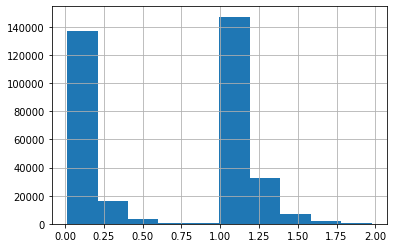

In [81]:
dock_station_train_merged.loc[dock_station_train_merged['Percent_usage']<2]['Percent_usage'].hist()

In [28]:
dock_station_merged.to_csv('train.csv')

### Merge Dockstation with test dataset

In [58]:
dockdf_merged_test = test_df_weather.merge(dockdf,how='left',on=['start_station_name','start_date'])
dock_station_test_merged = dockdf_merged_test.merge(dock_station,how='left',on=['start_station_name'])
print(dock_station_test_merged.tot_docks.isna().sum())
mask1 = (dock_station_test_merged['tot_docks']<=10) & (dock_station_test_merged['capacity']>20)
dock_station_test_merged.tot_docks[mask1] = np.nan
print(dock_station_test_merged.tot_docks.isna().sum())
dock_station_test_merged['tot_docks'] = dock_station_test_merged['tot_docks'].fillna(dock_station_test_merged['capacity'])
dock_station_test_merged.tot_docks.isna().sum()

2342120


C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


2342979


157573

In [59]:
dock_station_test_merged.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity
0,1728,2017-01-16 14:07:10,2017-01-16 14:35:59,301.0,E 2 St & Avenue B,40.722174,-73.983688,279.0,Peck Slip & Front St,40.707873,-74.001670,25015,2017-01-16,2017,1,16,14,1,1,1,2017-01-16,14,8.0,4.0,12.0,6.0,4.0,10.0,1.939856,23387,713.239278,1.343726,134.0,680.604478,1.148099,8.0,761.000000,1.106751,4.70,0.00,0.0,0.0,43,30,0.0,0.0,0.0,0.0,0.0,0.0,36.5,0,0,58.0,58.0
1,128,2017-01-17 17:25:50,2017-01-17 17:27:58,350.0,Clinton St & Grand St,40.715595,-73.987030,291.0,Madison St & Montgomery St,40.713126,-73.984844,26838,2017-01-17,2017,1,17,17,2,1,0,2017-01-17,17,1.0,5.0,6.0,1.0,8.0,9.0,0.286199,18190,661.653161,1.369798,131.0,526.954198,0.883908,1.0,128.000000,0.286199,4.92,0.35,0.0,0.0,42,38,1.0,0.0,0.0,0.0,0.0,1.0,40.0,1,0,28.0,28.0
2,352,2017-01-20 15:30:57,2017-01-20 15:36:49,435.0,W 21 St & 6 Ave,40.741740,-73.994156,509.0,9 Ave & W 22 St,40.745497,-74.001971,16996,2017-01-20,2017,1,20,15,5,1,0,2017-01-20,15,16.0,8.0,24.0,4.0,25.0,29.0,0.673514,25833,683.189680,1.359980,375.0,629.480000,1.101935,16.0,480.500000,0.987935,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,50.0,50.0
3,367,2017-01-31 08:53:43,2017-01-31 08:59:51,517.0,Pershing Square South,40.751581,-73.977910,523.0,W 38 St & 8 Ave,40.754666,-73.991382,14647,2017-01-31,2017,1,31,8,2,1,0,2017-01-31,8,23.0,26.0,49.0,16.0,17.0,33.0,0.926849,24545,645.918150,1.328383,591.0,677.368866,1.639718,23.0,673.521739,1.605749,4.03,0.06,1.0,0.0,34,26,1.0,1.0,0.0,0.0,0.0,1.0,30.0,1,1,69.0,69.0
4,419,2017-01-04 14:07:41,2017-01-04 14:14:40,3120.0,Center Blvd & Borden Ave,40.741610,-73.960440,3125.0,45 Rd & 11 St,40.747086,-73.949772,20232,2017-01-04,2017,1,4,14,3,1,0,2017-01-04,14,2.0,1.0,3.0,0.0,4.0,4.0,0.943220,33455,714.582663,1.407101,15.0,918.800000,1.294628,2.0,301.000000,0.687617,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,NaN,NaN


In [60]:
# Impute missing values in tot_docks for all stations
missing = list(dock_station_test_merged.loc[dock_station_test_merged.tot_docks.isna()]['start_station_ID'].unique())
for i in missing:
    missingrows = len(dock_station_test_merged.loc[(dock_station_test_merged['start_station_ID']==i)\
                                                    & (dock_station_test_merged['tot_docks'].isna())])
    if len(dock_station_test_merged.loc[(dock_station_test_merged['start_station_ID']==i)]) != missingrows:
        mask =  (dock_station_test_merged['start_station_ID']==i) & (dock_station_test_merged['tot_docks'].isna())
        med = dock_station_test_merged.loc[(dock_station_test_merged['start_station_ID']==i)]['tot_docks'].median()
        dock_station_test_merged.loc[mask,'tot_docks']=dock_station_test_merged.loc[mask,'tot_docks'].fillna(med) 
dock_station_test_merged.loc[dock_station_test_merged.tot_docks.isna()]['start_station_ID'].nunique()

53

In [61]:
# Name is not matching or station is obselete 
missing1 = list(dock_station_test_merged.loc[dock_station_test_merged.tot_docks.isna()]['start_station_ID'].unique())
dock_station_test_merged.loc[dock_station_test_merged['start_station_ID'].isin(missing1)]

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity
1428,449,2017-01-20 19:09:11,2017-01-20 19:16:41,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,393.0,E 5 St & Avenue C,40.722992,-73.979955,25159,2017-01-20,2017,1,20,19,5,1,0,2017-01-20,19,4.0,5.0,9.0,3.0,4.0,7.0,0.611346,25833,683.189680,1.359980,67.0,602.462687,1.199091,4.0,580.500000,1.218672,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,NaN,NaN
1861,904,2017-01-26 09:47:28,2017-01-26 10:02:32,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,315.0,South St & Gouverneur Ln,40.703554,-74.006702,18503,2017-01-26,2017,1,26,9,4,1,0,2017-01-26,10,3.0,0.0,3.0,1.0,2.0,3.0,2.364366,32084,685.643872,1.364001,128.0,678.679688,1.379311,3.0,486.666667,1.212054,6.71,0.02,0.0,0.0,56,43,0.0,0.0,0.0,0.0,0.0,0.0,49.5,1,0,NaN,NaN
2505,67,2017-01-20 15:33:15,2017-01-20 15:34:23,3036.0,8D OPS 01,40.517975,-74.031372,3036.0,8D OPS 01,40.517975,-74.031372,21928,2017-01-20,2017,1,20,15,5,1,0,2017-01-20,15,1.0,1.0,2.0,1.0,1.0,2.0,0.138764,25833,683.189680,1.359980,1.0,67.000000,0.138764,1.0,67.000000,0.138764,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,NaN,NaN
2510,999,2017-01-27 08:57:14,2017-01-27 09:13:54,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,304.0,Broadway & Battery Pl,40.704633,-74.013617,25923,2017-01-27,2017,1,27,8,5,1,0,2017-01-27,9,14.0,2.0,16.0,3.0,23.0,26.0,2.656360,31465,677.758303,1.340342,162.0,774.932099,1.766274,14.0,722.000000,1.953944,8.95,0.00,0.0,0.0,43,36,0.0,0.0,0.0,0.0,0.0,0.0,39.5,0,0,NaN,NaN
2673,309,2017-01-22 10:34:28,2017-01-22 10:39:37,3237.0,21 St & 41 Ave,40.753833,-73.942677,3125.0,45 Rd & 11 St,40.747086,-73.949772,25321,2017-01-22,2017,1,22,10,7,0,0,2017-01-22,10,1.0,1.0,2.0,2.0,3.0,5.0,0.841647,19222,756.941629,1.352758,7.0,974.857143,1.473112,1.0,309.000000,0.841647,6.71,0.05,0.0,0.0,48,43,1.0,1.0,0.0,0.0,0.0,1.0,45.5,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492865,546,2019-12-05 22:34:59.626,2019-12-05 22:44:06.291,3788.0,E 12 St & 4 Av,40.732690,-73.989740,150.0,E 2 St & Avenue C,40.720874,-73.980858,33824,2019-12-05,2019,12,5,22,4,1,0,2019-12-05,22,12.0,2.0,14.0,1.0,10.0,11.0,1.286080,47520,701.236385,1.340049,74.0,455.635135,0.907450,12.0,498.000000,1.206575,9.40,0.00,0.0,0.0,42,36,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0,0,NaN,NaN
2492895,645,2019-12-07 18:31:30.660,2019-12-07 18:42:16.423,3810.0,Central Park West & W 82 St,40.782593,-73.971211,3341.0,Central Park West & W 102 St,40.795346,-73.961860,35267,2019-12-07,2019,12,7,18,6,0,0,2019-12-07,18,2.0,2.0,4.0,1.0,2.0,3.0,1.375560,32371,754.944549,1.280923,41.0,869.756098,1.650140,2.0,541.000000,1.375560,6.93,0.00,0.0,0.0,38,30,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0,0,NaN,NaN
2492994,266,2019-12-06 16:32:25.695,2019-12-06 16:36:52.470,3908.0,Battery Pl & Greenwich St,40.704630,-74.015070,315.0,South St & Gouverneur Ln,40.703554,-74.006702,38348,2019-12-06,2019,12,6,16,5,1,0,2019-12-06,16,7.0,3.0,10.0,4.0,8.0,12.0,0.517750,49943,717.196524,1.345852,144.0,1268.597222,2.114846,7.0,883.285714,1.925159,7.38,0.00,0.0,0.0,50,34,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0,0,NaN,NaN
2493498,932,2019-12

In [65]:
# Sanity check and overwrite errors in dock capacity 
mask = dock_station_test_merged['tot_docks']!=0 
dock_station_test_merged = dock_station_test_merged[mask]# remove stations that have 0 tot_docks
# mask1 = (dock_station_train_merged['tot_docks']==1) & (dock_station_train_merged['start_station_ID']==3459)
# dock_station_train_merged['tot_docks'][mask1]=34 ### impute tot_docks due to nonsense total_docks for a few entries
# mask2 = (dock_station_train_merged['tot_docks']==7) & (dock_station_train_merged['start_station_ID']==3255)
# dock_station_train_merged['tot_docks'][mask2]=19 ### impute tot_docks due to nonsense total_docks for a few entries
# mask3 = (dock_station_train_merged['tot_docks']==3) & (dock_station_train_merged['start_station_ID']==3467)
# dock_station_train_merged['tot_docks'][mask3]=44 ### impute tot_docks due to nonsense total_docks for a few entries

In [66]:
dock_station_test_merged.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity
0,1728,2017-01-16 14:07:10,2017-01-16 14:35:59,301.0,E 2 St & Avenue B,40.722174,-73.983688,279.0,Peck Slip & Front St,40.707873,-74.001670,25015,2017-01-16,2017,1,16,14,1,1,1,2017-01-16,14,8.0,4.0,12.0,6.0,4.0,10.0,1.939856,23387,713.239278,1.343726,134.0,680.604478,1.148099,8.0,761.000000,1.106751,4.70,0.00,0.0,0.0,43,30,0.0,0.0,0.0,0.0,0.0,0.0,36.5,0,0,58.0,58.0
1,128,2017-01-17 17:25:50,2017-01-17 17:27:58,350.0,Clinton St & Grand St,40.715595,-73.987030,291.0,Madison St & Montgomery St,40.713126,-73.984844,26838,2017-01-17,2017,1,17,17,2,1,0,2017-01-17,17,1.0,5.0,6.0,1.0,8.0,9.0,0.286199,18190,661.653161,1.369798,131.0,526.954198,0.883908,1.0,128.000000,0.286199,4.92,0.35,0.0,0.0,42,38,1.0,0.0,0.0,0.0,0.0,1.0,40.0,1,0,28.0,28.0
2,352,2017-01-20 15:30:57,2017-01-20 15:36:49,435.0,W 21 St & 6 Ave,40.741740,-73.994156,509.0,9 Ave & W 22 St,40.745497,-74.001971,16996,2017-01-20,2017,1,20,15,5,1,0,2017-01-20,15,16.0,8.0,24.0,4.0,25.0,29.0,0.673514,25833,683.189680,1.359980,375.0,629.480000,1.101935,16.0,480.500000,0.987935,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,50.0,50.0
3,367,2017-01-31 08:53:43,2017-01-31 08:59:51,517.0,Pershing Square South,40.751581,-73.977910,523.0,W 38 St & 8 Ave,40.754666,-73.991382,14647,2017-01-31,2017,1,31,8,2,1,0,2017-01-31,8,23.0,26.0,49.0,16.0,17.0,33.0,0.926849,24545,645.918150,1.328383,591.0,677.368866,1.639718,23.0,673.521739,1.605749,4.03,0.06,1.0,0.0,34,26,1.0,1.0,0.0,0.0,0.0,1.0,30.0,1,1,69.0,69.0
4,419,2017-01-04 14:07:41,2017-01-04 14:14:40,3120.0,Center Blvd & Borden Ave,40.741610,-73.960440,3125.0,45 Rd & 11 St,40.747086,-73.949772,20232,2017-01-04,2017,1,4,14,3,1,0,2017-01-04,14,2.0,1.0,3.0,0.0,4.0,4.0,0.943220,33455,714.582663,1.407101,15.0,918.800000,1.294628,2.0,301.000000,0.687617,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,20.0,NaN


In [67]:
dock_station_test_merged['Percent_usage'] = (dock_station_test_merged['start_station_checkin_counts']+\
                                              dock_station_test_merged['start_station_checkout_counts']/\
                                              dock_station_test_merged['tot_docks'])

dock_station_test_merged[['Percent_usage']].describe()   

,Percent_usage
count,2.469969e+06
mean,1.137072e+01
std,1.261565e+01
min,1.265823e-02
25%,3.179487e+00
50%,7.612245e+00
75%,1.527660e+01
max,2.420196e+02


In [69]:
dock_station_test_merged.loc[dock_station_test_merged['Percent_usage']>10]#['start_station_ID'].unique()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity,Percent_usage
3,367,2017-01-31 08:53:43,2017-01-31 08:59:51,517.0,Pershing Square South,40.751581,-73.977910,523.0,W 38 St & 8 Ave,40.754666,-73.991382,14647,2017-01-31,2017,1,31,8,2,1,0,2017-01-31,8,23.0,26.0,49.0,16.0,17.0,33.0,0.926849,24545,645.918150,1.328383,591.0,677.368866,1.639718,23.0,673.521739,1.605749,4.03,0.06,1.0,0.0,34,26,1.0,1.0,0.0,0.0,0.0,1.0,30.0,1,1,69.0,69.0,26.333333
9,1706,2017-01-18 07:48:44,2017-01-18 08:17:10,519.0,Pershing Square North,40.751873,-73.977706,337.0,Old Slip & Front St,40.703799,-74.008387,25166,2017-01-18,2017,1,18,7,3,1,0,2017-01-18,8,45.0,35.0,80.0,1.0,16.0,17.0,4.943172,30239,696.581038,1.375749,695.0,728.987050,1.713258,45.0,670.688889,1.708626,5.82,0.06,0.0,0.0,41,38,1.0,0.0,0.0,0.0,0.0,0.0,39.5,1,0,61.0,69.0,35.737705
10,781,2017-01-11 17:40:24,2017-01-11 17:53:26,461.0,E 20 St & 2 Ave,40.735877,-73.982050,3435.0,Grand St & Elizabeth St,40.718822,-73.995960,27159,2017-01-11,2017,1,11,17,3,1,0,2017-01-11,17,16.0,11.0,27.0,13.0,15.0,28.0,1.913996,32036,712.750936,1.415919,199.0,637.809045,1.252051,16.0,814.812500,1.539019,5.82,0.52,0.0,0.0,52,42,1.0,0.0,0.0,0.0,0.0,0.0,47.0,1,0,56.0,56.0,11.285714
28,600,2017-01-19 08:43:14,2017-01-19 08:53:15,540.0,Lexington Ave & E 29 St,40.743116,-73.982154,362.0,Broadway & W 37 St,40.751726,-73.987535,26588,2017-01-19,2017,1,19,8,4,1,0,2017-01-19,8,18.0,20.0,38.0,10.0,13.0,23.0,0.879373,35672,708.974658,1.420254,248.0,523.536290,1.094002,18.0,436.888889,0.944435,3.58,0.00,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,30.0,46.0,20.600000
29,650,2017-01-10 08:36:58,2017-01-10 08:47:49,3255.0,8 Ave & W 31 St,40.750585,-73.994685,423.0,W 54 St & 9 Ave,40.765849,-73.986905,27104,2017-01-10,2017,1,10,8,2,1,0,2017-01-10,8,14.0,12.0,26.0,2.0,1.0,3.0,1.465547,22722,670.258472,1.317401,344.0,733.991279,1.519250,14.0,771.357143,1.579683,4.70,0.00,0.0,3.1,46,21,0.0,0.0,0.0,0.0,0.0,0.0,33.5,0,0,19.0,19.0,12.736842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494095,344,2019-12-27 12:22:35.839,2019-12-27 12:28:19.842,379.0,W 31 St & 7 Ave,40.749156,-73.991600,388.0,W 26 St & 10 Ave,40.749718,-74.002950,34059,2019-12-27,2019,12,27,12,5,1,0,2019-12-27,12,15.0,13.0,28.0,6.0,9.0,15.0,0.640329,30477,812.480789,1.347163,168.0,1157.880952,1.166866,15.0,487.466667,0.822229,4.47,0.00,0.0,0.0,54,46,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0,0,42.0,42.0,13.357143
2494097,580,2019-12-11 18:42:52.093,2019-12-11 18:52:32.875,426.0,West St & Chambers St,40.717548,-74.013221,346.0,Bank St & Hudson St,40.736529,-74.006180,40306,2019-12-11,2019,12,11,18,3,1,0,2019-12-11,18,18.0,17.0,35.0,4.0,9.0,13.0,1.682801,37143,669.022938,1.261227,233.0,950.369099,2.123189,18.0,1008.777778,2.571563,6.26,0.26,0.2,0.0,40,31,1.0,0.0,0.0,0.0,0.0,0.0,35.5,1,1,29.0,29.0,17.620690
2494102,517,2019-12-11 14:17:04.221,2019-12-11 14:25:41.784,223.0,W 13 St & 7 Ave,40.737815,-73.999947,347.0,Greenwich St & W Houston St,40.728846,-74.008591,20989,2019-12-11,2019,12,11,14,3,1,0,2019-12-11,14,6.0,10.0,16.0,8.0,5.0,13.0,1.077020,37143,669.022938,1.261227,193